In [17]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [18]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [19]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [20]:
gemma_metric["score"].mean() * 100

2.9098915989159893

In [21]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [24]:
brute_model = pd.DataFrame(brute_sentences)

In [27]:
brute = bipartite_metric(brute_model, ground_truth)

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [30]:
brute["score"].mean() * 100

2.050442924314776

In [33]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() * 100

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


1.8895663956639563

In [34]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [35]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

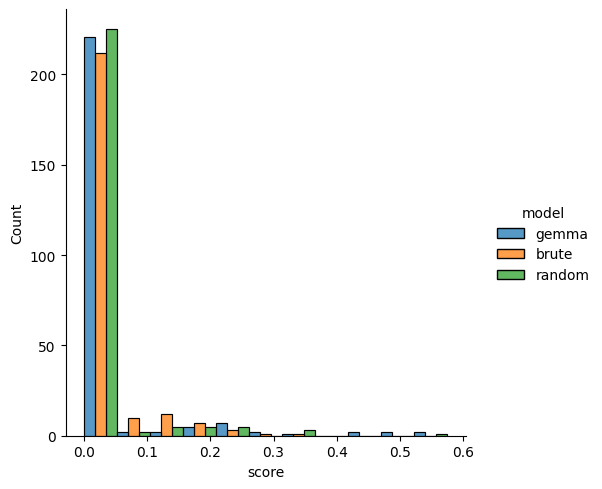

In [36]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")